# Set up Preliminaries

In [1]:
### IMPORT PACKAGES ###
import fasttext
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display_html
from itertools import chain,cycle
from sklearn.decomposition import PCA

### FILTER WARNINGS ###
# np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [2]:
### lOAD WORD EMBEDDINGS ###
# https://fasttext.cc/docs/en/crawl-vectors.html
fil = fasttext.load_model('cc.tl.300.bin')
#eng = fasttext.load_model('cc.en.300.bin')

In [4]:
### INITIALIZE VARIABLES ###

# Filipino gendered seed words

# based on 10 most common derivatives of 'lalaki' and 'babae' in the training corpus
fil_directly_male = ['lalaki', 'lalaking', 'lalake', 'kalalakihan', 'lalakeng', 
                 'pagkalalaki', 'panlalaki', 'pagkalalake', 'kalalakihang', 'panlalaking']
fil_directly_female = ['babae', 'babaeng', 'kababaihan', 'pagkababae', 'babaing', 
                   'kababaihang', 'pambabae', 'pambabaeng', 'Kababaihan', 'babae.']

fil_male_marked = ['ama', 'bana', 'bayaw', 'binata', 'binatilyo', 'biyudo', 'bulugan', 'diko', 'duke', 'emperador', 
               'G.', 'ginoo', 'hari', 'ingkong', 'kalakian', 'konde', 'kumpadre', 'kumpare', 'kuya', 'lakan',
               'lakandiwa', 'lolo', 'mayordomo', 'monghe', 'padre', 'pare', 'pari', 'patriyarka', 'prinsipe', 'sangko',
               'sireno', 'tandang', 'tatay', 'tinali', 'tito', 'tiyo', 'tiyuhin']
fil_female_marked = ['ate', 'babaylan', 'Bb.', 'binibini', 'biyuda', 'dalaginding', 'dalagita', 'ditse', 'dukesa', 'dumalaga',
                 'emperatris', 'ginang', 'Gng.', 'hipag', 'impo', 'ina', 'inahin', 'kondesa', 'kumare', 'lakambini',
                 'lola', 'madrasta', 'madre', 'mare', 'matriyarka', 'nanay', 'prinsesa', 'reyna', 'sanse', 'sirena', 
                 'tita', 'tiya', 'tiyahin']

fil_male = fil_directly_male + fil_male_marked
fil_female = fil_directly_female + fil_female_marked

In [5]:
### DEFINE VARIABLES ###

# Compute cosine similarity between a word and a list of
# words pertaining to an attribute
def word_attr_sim(emb, word, attr_list):
    sum_of_sims = 0
    
    for attr_word in attr_list:
        word_vec = np.array([emb[word]])
        attr_word_vec = np.array([emb[attr_word]])
        sim = cosine_similarity(word_vec, attr_word_vec)
        sum_of_sims += sim
        
    mean_sim = sum_of_sims / len(attr_list)
    
    return mean_sim

# Compute word's association with an attribute pair
def get_assoc(emb, word, attr_list_1, attr_list_2):
    return word_attr_sim(emb, word, attr_list_1) - word_attr_sim(emb, word, attr_list_2)

# Validate Gender Information in Filipino Emedding

In [6]:
# What percentage of male-marked words are more similar to
# directly male-denoting words compared to directly female-
# denoting ones?
gender_assocs = pd.DataFrame(columns = ['word', 'lexical_gender', 'assoc_score', 'emb_gender_assoc', 'valid_emb_assoc'])

for word in fil_male_marked:
    lexical_gender = 'male'
    assoc_score = get_assoc(fil, word, fil_directly_male, fil_directly_female)
    emb_gender_assoc = 'male' if assoc_score > 0 else 'female'
    valid_emb_assoc = 1 if emb_gender_assoc == lexical_gender else 0
    
    new_row = [word, lexical_gender, assoc_score, emb_gender_assoc, valid_emb_assoc]
    gender_assocs.loc[len(gender_assocs)] =  new_row

for word in fil_female_marked:
    lexical_gender = 'female'
    assoc_score = get_assoc(fil, word, fil_directly_male, fil_directly_female)
    emb_gender_assoc = 'male' if assoc_score > 0 else 'female'
    valid_emb_assoc = 1 if emb_gender_assoc == lexical_gender else 0
    
    new_row = [word, lexical_gender, assoc_score, emb_gender_assoc, valid_emb_assoc]
    gender_assocs.loc[len(gender_assocs)] =  new_row

valid_perc = np.mean(gender_assocs['valid_emb_assoc'])

print(f"The Filipino FastText embedding accurately represents the gender of {valid_perc:.2%} of chosen gender-marked seed words.")

The Filipino FastText embedding accurately represents the gender of 78.57% of chosen gender-marked seed words.


In [7]:
gender_assocs[gender_assocs['valid_emb_assoc']==0]

,word,lexical_gender,assoc_score,emb_gender_assoc,valid_emb_assoc
1,bana,male,[[-0.041781783]],female,0
11,ginoo,male,[[-0.034263298]],female,0
13,ingkong,male,[[-0.012156785]],female,0
20,lakandiwa,male,[[-0.009155631]],female,0
23,monghe,male,[[-0.020930544]],female,0
24,padre,male,[[-0.052762873]],female,0
26,pari,male,[[-0.009120256]],female,0
27,patriyarka,male,[[-0.0014751256]],female,0
35,tiyo,male,[[-0.021142468]],female,0
43,dalagita,female,[[0.015358776]],male,0


In [8]:
# Gendered word vectors that properly capture gendered information
correct_fil_male = list(fil_directly_male)
correct_fil_female = list(fil_directly_female)

for word in fil_male_marked:
    idx = gender_assocs[gender_assocs['word']==word].index.values.astype(int)[0]
    valid = gender_assocs.iloc[idx,4]
    if valid:
        correct_fil_male.append(word)
        
for word in fil_female_marked:
    idx = gender_assocs[gender_assocs['word']==word].index.values.astype(int)[0]
    valid = gender_assocs.iloc[idx,4]
    if valid:
        correct_fil_female.append(word)

correct_fil_male

['lalaki',
 'lalaking',
 'lalake',
 'kalalakihan',
 'lalakeng',
 'pagkalalaki',
 'panlalaki',
 'pagkalalake',
 'kalalakihang',
 'panlalaking',
 'ama',
 'bayaw',
 'binata',
 'binatilyo',
 'biyudo',
 'bulugan',
 'diko',
 'duke',
 'emperador',
 'G.',
 'hari',
 'kalakian',
 'konde',
 'kumpadre',
 'kumpare',
 'kuya',
 'lakan',
 'lolo',
 'mayordomo',
 'pare',
 'prinsipe',
 'sangko',
 'sireno',
 'tandang',
 'tatay',
 'tinali',
 'tito',
 'tiyuhin']

# Calculate Gender Association Scores

# Visualize Gender Association Scores

In [9]:
fil_ube_list = pd.read_excel('fil_fasttext_weat.xlsx')

fil_ube_list.head(10)

,freq_rank,word,assoc_score,gender_assoc,assoc_mgntd,z,z_abs,pos,lex_gen,lang,rep,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,9604,Gng,-0.080191,female,0.080191,-4.685075,4.685075,cnn,1.0,tl,orig,NaN,41355.0,0.8271
1,19969,Ms,-0.074081,female,0.074081,-4.396195,4.396195,cnn,1.0,en,orig,NaN,8645.0,0.1729
2,39970,nÃ©e,-0.072917,female,0.072917,-4.341155,4.341155,inv,0.0,NaN,NaN,NaN,50000.0,NaN
3,33697,Lila,-0.072519,female,0.072519,-4.322302,4.322302,adj,0.0,tl,orig,NaN,NaN,NaN
4,37615,Tia,-0.071494,female,0.071494,-4.273872,4.273872,cnn,1.0,tl,orig,NaN,NaN,NaN
5,40310,lily,-0.070877,female,0.070877,-4.244694,4.244694,cnn,0.0,en,orig,NaN,NaN,NaN
6,31252,VJ,-0.070288,female,0.070288,-4.216842,4.216842,pnn,1.0,NaN,NaN,NaN,NaN,NaN
7,9175,maybahay,-0.070194,female,0.070194,-4.212382,4.212382,cnn,0.0,tl,orig,NaN,NaN,NaN
8,39720,stylist,-0.068606,female,0.068606,-4.137278,4.137278,cnn,0.0,en,orig,NaN,NaN,NaN
9,33235,Dana,-0.068454,female,0.068454,-4.130103,4.130103,pnn,1.0,NaN,NaN,NaN,NaN,NaN


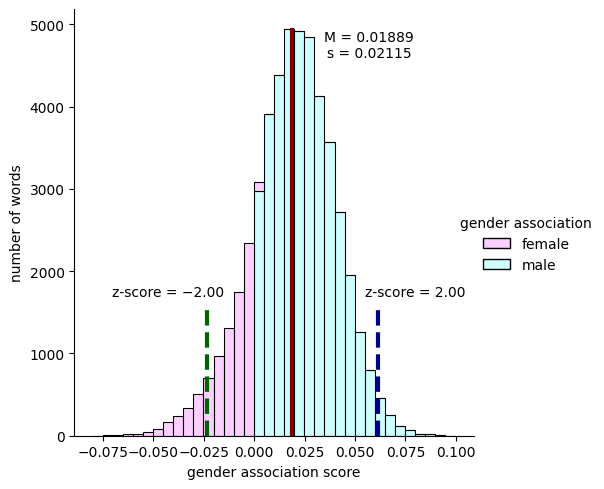

In [10]:
biasscore_plot = sns.displot(fil_ube_list, x="assoc_score", binwidth=0.005,
                            hue="gender_assoc", palette={'male':'#C0FEFE', 'female':'#FAC0FE'}, multiple='stack')
biasscore_plot.set(xlabel = 'gender association score', ylabel = 'number of words')
biasscore_plot._legend.set_title('gender association')

plt.axvline(x=-0.023406851, ymin=0, ymax = 0.3, linestyle='--', linewidth=3, color='darkgreen')
# plt.axvline(x=-0.002258947, ymin=0, ymax = 0.5, linestyle='--', linewidth=3, color='darkgreen')
plt.axvline(x=0.018888957077865, ymin=0, ymax = 0.95, linestyle='-', linewidth=3, color='maroon')
# plt.axvline(x=0.040036861, ymin=0, ymax = 0.5, linestyle='--', linewidth=3, color='darkblue')
plt.axvline(x=0.061184765, ymin=0, ymax = 0.3, linestyle='--', linewidth=3, color='darkblue')

plt.text(-0.015, 1700, 'z-score = −2.00', ha='right')
plt.text(0.055, 1700, 'z-score = 2.00', ha='left')
plt.text(0.057, 4600, 'M = 0.01889\ns = 0.02115', 
         ha='center')

plt.savefig('viz_assoc_dist.png')

In [11]:
male = fil_ube_list['gender_assoc']=='male'
female = fil_ube_list['gender_assoc']=='female'
biased = fil_ube_list['z_abs']>=2.00

female_biased_cnt = fil_ube_list[female & biased]['word'].count()
male_biased_cnt = fil_ube_list[male & biased]['word'].count()

print('Among the training corpus\'s 50,000 most frequent tokens, there are ' + str(female_biased_cnt) + ' tokens with strong implicit female bias.')
print('Among the training corpus\'s 50,000 most frequent tokens, there are ' + str(male_biased_cnt) + ' tokens with strong implicit male bias.')

Among the training corpus's 50,000 most frequent tokens, there are 1668 tokens with strong implicit female bias.
Among the training corpus's 50,000 most frequent tokens, there are 800 tokens with strong implicit male bias.


# Enumerate Implicitly Biased Words

In [12]:
def ube(gender, pos, lang):
    gender_ = fil_ube_list['gender_assoc']==gender
    pos_ = fil_ube_list['pos']==pos
    lang_ = fil_ube_list['lang']==lang
    rep_ = fil_ube_list['rep']=='orig'
    lex_gen_ = fil_ube_list['lex_gen']==0
    
    return fil_ube_list[gender_ & pos_ & lang_ & rep_ & lex_gen_].loc[:,['word','assoc_score','z']]

# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

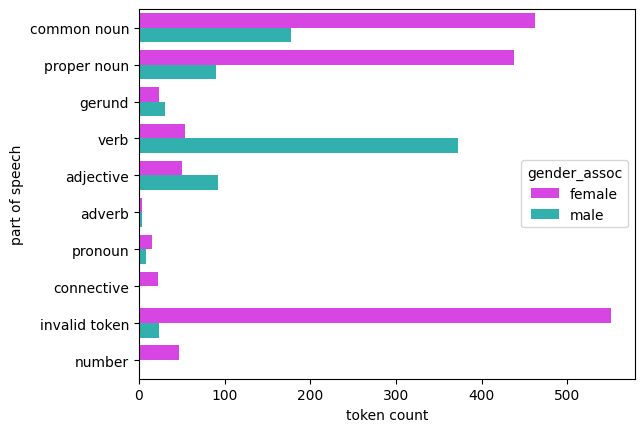

In [13]:
pos_order = ['cnn','pnn','grnd','vb','adj','dvrb','rnn','knk','inv','num']
pos_list = ['common noun','proper noun','gerund','verb','adjective',
            'adverb','pronoun','connective','invalid token','number',]

pos_count = sns.countplot(data=fil_ube_list, y='pos', order=pos_order,
                          hue='gender_assoc', palette={'male':'#1CC5C1', 'female':'#ED2CFC'})
pos_count.set(yticks=range(len(pos_list)), yticklabels=[i for i in pos_list],
              ylabel='part of speech', xlabel = 'token count')

plt.savefig('viz_pos_count.png',dpi=300, bbox_inches = "tight")

In [14]:
pivot_count = pd.pivot_table(fil_ube_list, values='word', 
                             index='pos', columns='gender_assoc',
                             aggfunc='count')

pivot_percOfPos = pd.DataFrame(columns=['pos','female','male'])
for row in range(len(pos_order)):
    row_sum = pivot_count.iloc[row,0] + pivot_count.iloc[row,1]
    female_perc = pivot_count.iloc[row,0]/row_sum
    male_perc = pivot_count.iloc[row,1]/row_sum
    pos = pivot_count.index[row]
    
    new_row = [pos,female_perc,male_perc]
    pivot_percOfPos.loc[len(pivot_percOfPos)] = new_row
pivot_percOfPos.set_index('pos', inplace=True)
    
pivot_percOfGender = pd.DataFrame(columns=['pos','female','male'])
for row in range(len(pos_order)):
    female_perc = pivot_count.iloc[row,0]/female_biased_cnt
    male_perc = pivot_count.iloc[row,1]/male_biased_cnt
    pos = pivot_count.index[row]
    
    new_row = [pos,female_perc,male_perc]
    pivot_percOfGender.loc[len(pivot_percOfGender)] = new_row
pivot_percOfGender.set_index('pos', inplace=True)

display_side_by_side(pivot_count,pivot_percOfPos, pivot_percOfGender,
                     titles=['POS and Gender: Counts',
                             'POS and Gender: \n % of POS',
                             'POS and Gender: \n % of Gender'])

gender_assoc,female,male
pos,,
adj,50,92
cnn,462,177
dvrb,4,4
grnd,24,31
inv,551,24
knk,22,1
num,47,1
pnn,438,90
rnn,16,8


In [15]:
display_side_by_side(ube('male','adj','tl').head(10),
                     ube('female','adj','tl').head(10),
                     ube('male','adj','en').head(10),
                     ube('female','adj','en').head(10),
                     titles=['Implicitly Male Adjectives (tl)',
                             'Implicitly Female Adjectives (tl)',
                             'Implicitly Male Adjectives (en)',
                             'Implicitly Female Adjectives (en)'])

,word,assoc_score,z
135,kakilakilabot,0.087646,3.251256
167,magkalabang,0.086235,3.184523
168,matikas,0.086182,3.182027
169,bagitong,0.086137,3.179875
187,pinakapuno,0.085270,3.138896
202,kalaki,0.084767,3.115110
274,napakatigas,0.081992,2.983882
291,papataas,0.081384,2.955132
295,matipunong,0.081165,2.944791
443,maangas,0.078061,2.798031


In [16]:
display_side_by_side(ube('male','cnn','tl').head(10),
                     ube('female','cnn','tl').head(10),
                     ube('male','cnn','en').head(10),
                     ube('female','cnn','en').head(10),
                     titles=['Implicitly Male Common Nouns (tl)',
                             'Implicitly Female Common Nouns (tl)',
                             'Implicitly Male Common Nouns (en)',
                             'Implicitly Female Common Nouns (en)'])

,word,assoc_score,z
74,tigas,0.092384,3.475268
131,tarugo,0.087774,3.257287
155,kilabot,0.086545,3.199179
158,lokong,0.086418,3.193180
183,burat,0.085480,3.148814
271,sandata,0.082109,2.989422
308,gagong,0.080970,2.935566
461,kalaban,0.077766,2.784050
468,yabang,0.077593,2.775864
498,etits,0.076939,2.744948


In [17]:
display_side_by_side(ube('male','grnd','tl').head(10),
                     ube('female','grnd','tl').head(10),
                     titles=['Implicitly Male Gerunds (tl)',
                             'Implicitly Female Gerunds (tl)'])

,word,assoc_score,z
76,pagmamayabang,0.092289,3.470800
78,pagjakol,0.091978,3.456105
153,pagtigas,0.086668,3.205014
198,pagchupa,0.084835,3.118307
296,pagkasabi,0.081162,2.944624
600,pananambang,0.075063,2.656244
645,pagbangga,0.074636,2.636057
1034,pagmamataas,0.069986,2.416164
1048,pananaig,0.069895,2.411880
1352,pagputok,0.067288,2.288598


In [18]:
display_side_by_side(ube('male','vb','tl').head(10),
                     ube('female','vb','tl').head(10),
                     ube('male','vb','en').head(10),
                     ube('female','vb','en').head(10),
                     titles=['Imp. Male Verbs (tl)',
                             'Imp. Female Verbs (tl)',
                             'Imp. Male Verbs (en)',
                             'Imp. Female Verbs (en)'])

,word,assoc_score,z
40,patigasin,0.098006,3.741140
81,umigkas,0.091776,3.446526
89,matamaan,0.090899,3.405055
95,nagyayabang,0.090465,3.384543
112,chupain,0.089070,3.318600
128,bumubukol,0.087965,3.266339
134,maisubo,0.087655,3.251685
159,makakatalo,0.086414,3.192978
184,sinalsal,0.085462,3.147992
248,papalag,0.082782,3.021253


In [19]:
display_side_by_side(ube('male','pnn','tl').head(10),
                     ube('female','pnn','tl').head(10),
                     ube('male','pnn','en').head(10),
                     ube('female','pnn','en').head(10),
                     titles=['Implicitly Male Proper Nouns (tl)',
                             'Implicitly Female Proper Nouns (tl)',
                             'Implicitly Male Proper Nouns (en)',
                             'Implicitly Female Proper Nouns (en)'])

,word,assoc_score,z
725,Filisteo,0.073414,2.578260
817,Diocleciano,0.072362,2.528533
1469,Judea,0.066304,2.242087
1881,Heorhiyano,0.064051,2.135511
2460,Ginebra,0.061225,2.001885
2466,Judio,0.061196,2.000511
,word,assoc_score,z
120,Kolkata,-0.050508,-3.281525
934,Indiya,-0.033172,-2.461776
983,MMK,-0.032661,-2.437614


# Visualize Implicit Bias Using PCA

In [20]:
correct_fil_gendered = [x for x in correct_fil_male + correct_fil_female if x in list(fil_ube_list['word'])]
directly_gendered = [x for x in fil_directly_male + fil_directly_female if x in list(fil_ube_list['word'])]
implicitly_biased = list(ube('male','adj','tl').iloc[0:10,0])+list(ube('female','adj','tl').iloc[0:10,0])+list(ube('male','cnn','tl').iloc[0:10,0])+list(ube('female','cnn','tl').iloc[0:10,0])+list(ube('male','grnd','tl').iloc[0:10,0])+list(ube('female','grnd','tl').iloc[0:10,0])+list(ube('male','vb','tl').iloc[0:10,0])+list(ube('female','vb','tl').iloc[0:10,0])

In [21]:
gendered_vecs = [fil.get_word_vector(x) for x in implicitly_biased]

pca = PCA(n_components=2)
gendered_vecs_PCA = pca.fit_transform(gendered_vecs)
exp_var = pca.explained_variance_ratio_
print(f"The first two PCs from a PCA of the gendered vectors explain {exp_var[0]:.2%} and {exp_var[1]:.2%} (sum of {np.sum(exp_var):.2%}) of the variance in the original vectors respectively.")

The first two PCs from a PCA of the gendered vectors explain 11.39% and 6.74% (sum of 18.13%) of the variance in the original vectors respectively.


In [22]:
transf_imp_biased_df = pd.DataFrame(columns=['word','gender','pos','PC1','PC2'])
    
for idx in range(len(implicitly_biased)):
    word = implicitly_biased[idx]
    gender = list(fil_ube_list[fil_ube_list.word == word]['gender_assoc'])[0]
    pos = list(fil_ube_list[fil_ube_list.word == word]['pos'])[0]
    PC1 = gendered_vecs_PCA[idx,0]
    PC2 = gendered_vecs_PCA[idx,1]
    new_row = [word,gender,pos,PC1,PC2]
        
    transf_imp_biased_df.loc[len(transf_imp_biased_df)] = new_row

transf_imp_biased_df

,word,gender,pos,PC1,PC2
0,kakilakilabot,male,adj,-0.031875,-0.109358
1,magkalabang,male,adj,-0.037247,-0.087109
2,matikas,male,adj,-0.177252,0.028246
3,bagitong,male,adj,-0.046364,-0.038638
4,pinakapuno,male,adj,-0.078956,-0.010579
...,...,...,...,...,...
75,nagpapaganda,female,vb,0.088837,-0.082734
76,nagpapasuso,female,vb,0.071419,0.017148
77,Alay,female,vb,0.276232,-0.316756
78,Ikinasal,female,vb,0.161418,-0.042594


<AxesSubplot: xlabel='PC1', ylabel='PC2'>

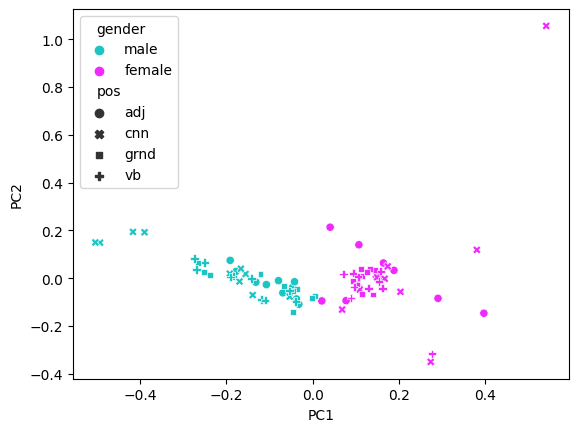

In [23]:
all_scatter = sns.scatterplot(data=transf_imp_biased_df, x='PC1', y='PC2', style='pos',
                              hue='gender', palette={'male':'#1CC5C1', 'female':'#ED2CFC'})

all_scatter

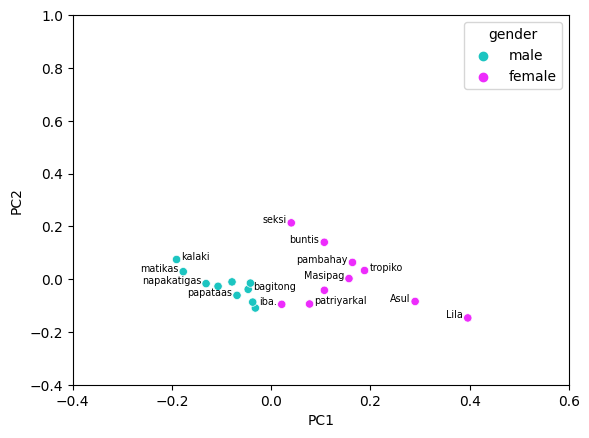

In [24]:
transf_imp_adj = transf_imp_biased_df[transf_imp_biased_df['pos']=='adj']
indices_left=[2,6,7,10,12,13,14,15,16,18]
indices_right=[3,5,11,19]

adj_scatter = sns.scatterplot(data=transf_imp_adj, x='PC1', y='PC2', 
                              hue='gender', palette={'male':'#1CC5C1', 'female':'#ED2CFC'})
adj_scatter.set_xlim(left=-0.4, right=0.6)
adj_scatter.set_ylim(bottom=-0.4, top=1.0)

for idx in indices_left:
     adj_scatter.text(transf_imp_adj.PC1[idx]-0.01, transf_imp_adj.PC2[idx], 
                      transf_imp_adj.word[idx], horizontalalignment='right', 
                      size='x-small', color='black', weight='light')

for idx in indices_right:
     adj_scatter.text(transf_imp_adj.PC1[idx]+0.01, transf_imp_adj.PC2[idx], 
                      transf_imp_adj.word[idx], horizontalalignment='left', 
                      size='x-small', color='black', weight='light')

adj_scatter

plt.savefig('viz_adj_pca.png',dpi=300, bbox_inches = "tight")

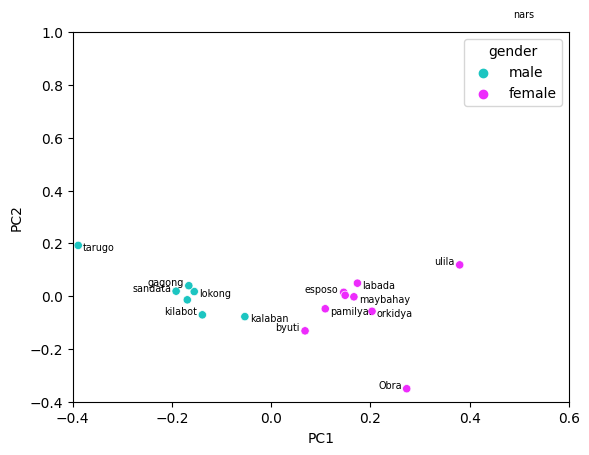

In [25]:
transf_imp_cnn = transf_imp_biased_df[transf_imp_biased_df['pos']=='cnn']
indices_left=[22,25,26,31,33,34,35,38]
indices_right=[21,23,27,30,32,37,39]

cnn_scatter = sns.scatterplot(data=transf_imp_cnn, x='PC1', y='PC2', 
                              hue='gender', palette={'male':'#1CC5C1', 'female':'#ED2CFC'})
cnn_scatter.set_xlim(left=-0.4, right=0.6)
cnn_scatter.set_ylim(bottom=-0.4, top=1.0)

for idx in indices_left:
    cnn_scatter.text(transf_imp_cnn.PC1[idx]-0.01, transf_imp_cnn.PC2[idx], 
                      transf_imp_cnn.word[idx], horizontalalignment='right', 
                      size='x-small', color='black', weight='light')

for idx in indices_right:
     cnn_scatter.text(transf_imp_cnn.PC1[idx]+0.01, transf_imp_cnn.PC2[idx]-0.02, 
                      transf_imp_cnn.word[idx], horizontalalignment='left', 
                      size='x-small', color='black', weight='light')

cnn_scatter

plt.savefig('viz_cnn_pca.png',dpi=300, bbox_inches = "tight")

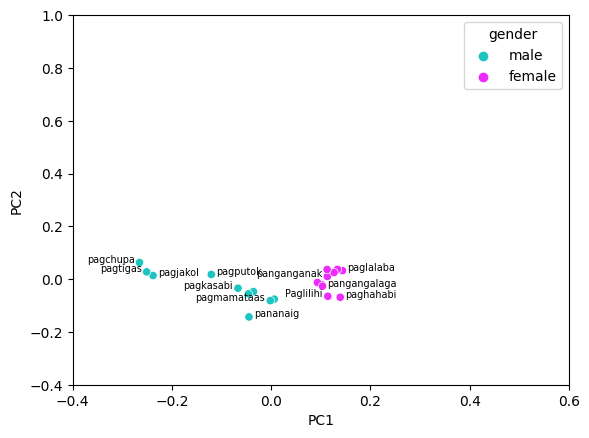

In [26]:
transf_imp_grnd = transf_imp_biased_df[transf_imp_biased_df['pos']=='grnd']
indices_left=[42,43,44,47,50,58]
indices_right=[41,48,49,51,56,57]

grnd_scatter = sns.scatterplot(data=transf_imp_grnd, x='PC1', y='PC2', 
                              hue='gender', palette={'male':'#1CC5C1', 'female':'#ED2CFC'})
grnd_scatter.set_xlim(left=-0.4, right=0.6)
grnd_scatter.set_ylim(bottom=-0.4, top=1.0)

for idx in indices_left:
    grnd_scatter.text(transf_imp_grnd.PC1[idx]-0.01, transf_imp_grnd.PC2[idx], 
                      transf_imp_grnd.word[idx], horizontalalignment='right', 
                      size='x-small', color='black', weight='light')

for idx in indices_right:
    grnd_scatter.text(transf_imp_grnd.PC1[idx]+0.01, transf_imp_grnd.PC2[idx], 
                      transf_imp_grnd.word[idx], horizontalalignment='left', 
                      size='x-small', color='black', weight='light')

grnd_scatter

plt.savefig('viz_grnd_pca.png',dpi=300, bbox_inches = "tight")

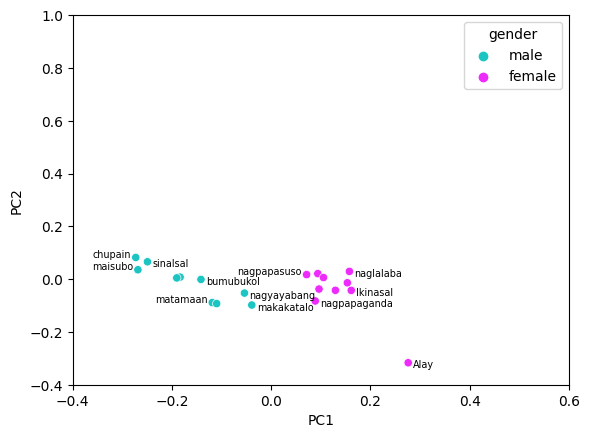

In [27]:
transf_imp_vb = transf_imp_biased_df[transf_imp_biased_df['pos']=='vb']
indices_left=[62,64,66,76]
indices_right=[63,65,67,68,70,75,77,78]

vb_scatter = sns.scatterplot(data=transf_imp_vb, x='PC1', y='PC2', 
                              hue='gender', palette={'male':'#1CC5C1', 'female':'#ED2CFC'})
vb_scatter.set_xlim(left=-0.4, right=0.6)
vb_scatter.set_ylim(bottom=-0.4, top=1.0)

for idx in indices_left:
    vb_scatter.text(transf_imp_vb.PC1[idx]-0.01, transf_imp_vb.PC2[idx], 
                      transf_imp_vb.word[idx], horizontalalignment='right', 
                      size='x-small', color='black', weight='light')

for idx in indices_right:
    vb_scatter.text(transf_imp_vb.PC1[idx]+0.01, transf_imp_vb.PC2[idx]-0.02, 
                      transf_imp_vb.word[idx], horizontalalignment='left', 
                      size='x-small', color='black', weight='light')

vb_scatter

plt.savefig('viz_vb_pca.png',dpi=300, bbox_inches = "tight")